In [120]:
# Importaciones necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, HuberRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline



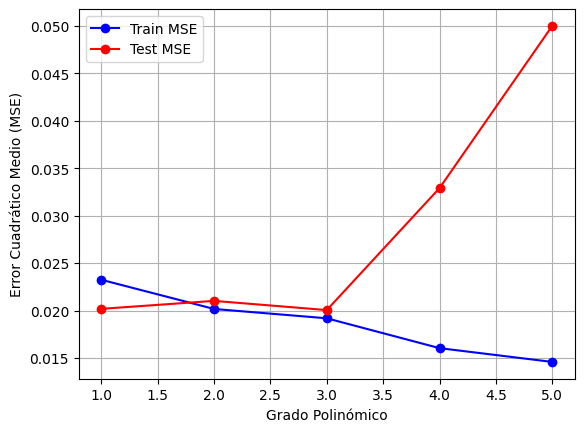

In [121]:
data=pd.read_csv('fundamental_plane.csv')                                               #cargamos datos
x=data[['log_sigma','mu']]                                                              #variables independientes
y=data['log_re_pc']                                                                     #variable dependiente

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)       #dividimos los datos en 70% train y 30% test

#Inicializamos las listas donde guardaremos los MSE
train_mses=[]
test_mses=[]

for i in range(1,6):                                                                    #Loop donde hacemos la regresion lineal para polinomios de grado 1 a 5    
    pipe=Pipeline([                                                   
        ('poly',PolynomialFeatures(degree=i)),                                          #hacemos la transformacion a polinomio                                                   
        ('scaller',StandardScaler()),                                                   #estandarizamos
        ('model',LinearRegression())                                                    #modelo OLS
    ]) 
    pipe.fit(x_train,y_train)                                                           #entrenamos el modelo y predecimos para ambos conjuntos
    y_train_pred=pipe.predict(x_train)
    y_test_pred=pipe.predict(x_test)

    train_mse=mean_squared_error(y_train,y_train_pred)                                  #calculamos MSE para ambos conjuntos y guardamos el valor
    test_mse=mean_squared_error(y_test,y_test_pred)
    train_mses.append(train_mse)
    test_mses.append(test_mse)

    

plt.plot(np.array(range(1,6)), train_mses, 'bo-', label='Train MSE')
plt.plot(np.array(range(1,6)), test_mses, 'ro-', label='Test MSE')
plt.xlabel('Grado Polinómico')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.legend()
plt.grid(True)
plt.show()

    



Con este grafico se puede observar claramente el problema de 'overfitting' donde al ir aumentando el grado del polinomio el modelo se va ajustando cada vez mejor a las particularidades del conjunto de entrenamiento, pero al intentar predecir en el conjunto de prueba este falla cada vez mas. En este caso el mejor modelo es el de grado 1 (es el mas simple de los modelos aceptables).

R^2 Ridge 0.8111475708543272
Coeficientes Ridge [0.         0.18499243 0.34313126]
R^2 Lasso 0.7296871499066916
Coeficientes Lasso [0.         0.09088763 0.24925383]


<function matplotlib.pyplot.show(close=None, block=None)>

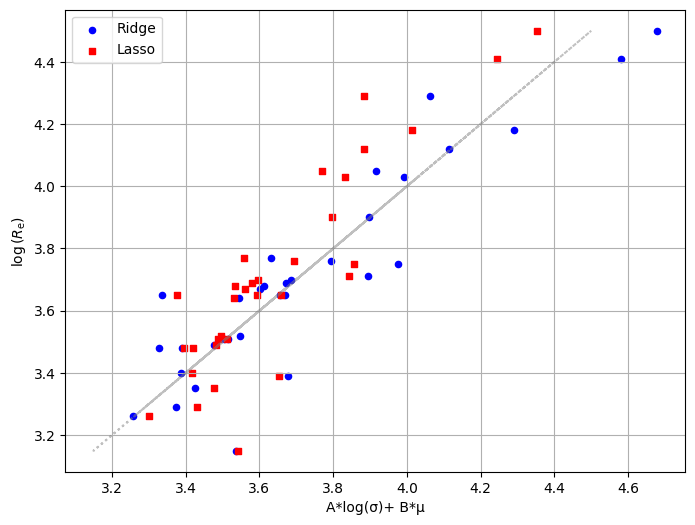

In [122]:
#Ahora aplicamos la regresion Ridge y Lasso para el polinomio de grado 1
models={'Ridge':(Ridge(alpha=0.1),'blue','o'),
        'Lasso':(Lasso(alpha=0.1),'red','s')}
fig = plt.figure(figsize=(8,6))
for name , model in models.items():                                                     #ajustamos para ambos modelos
    pipe=Pipeline([                                                   
        ('poly',PolynomialFeatures(degree=1)),                                          #hacemos la transformacion a polinomio de primer orden
        ('scaller',StandardScaler()),                                                   #estandarizamos
        ('model',model[0])                                                              #definimos modelo
    ])
    pipe.fit(x_train,y_train)                                                           #entrenamos y obtenemos los coeficientes 
    y_pred=pipe.predict(x_test)
    coef=pipe.named_steps['model'].coef_
    print('R^2',name,pipe.score(x_test,y_test))                                       #mostramos R^2 
    print('Coeficientes',name,str(coef))                                                #mostramos los coeficientes
    plt.scatter(y_pred, y_test,s=20, c=model[1],marker=model[2],label=name)
plt.plot(y_test,y_test,color='grey',alpha=0.5,linestyle='dotted')
plt.xlabel('A*log(σ)+ B*μ')
plt.ylabel(r'$\log\left(R_{\mathrm{e}}\right)$')
plt.grid(True)
plt.legend()
plt.show



Los coeficientes que obtenemos corresponden a intercepto, coef de log_sigma y coef de mu en ese orden, al comparar entre ambos modelos notamos que Lasso reduce mucho mas el coef de log_sigma en comparacion a Ridge, es decir el modelo determino que la variable log_sigma no es tan relevante (no es cierto). En el grafico el modelo que mejor se ajuste a nuestros datos sera el que este mas cercano a la identidad (linea gris), en este caso el mejor modelo corresponde a Ridge, puesto que, como ya mencionamos, este mantiene ambas caracteristicas, las cuales sabemos que son relevantes las 2, mientras que Lasso elimino la dependendia en log_sigma empeorando el ajuste.

R^2 0.8200021582242519


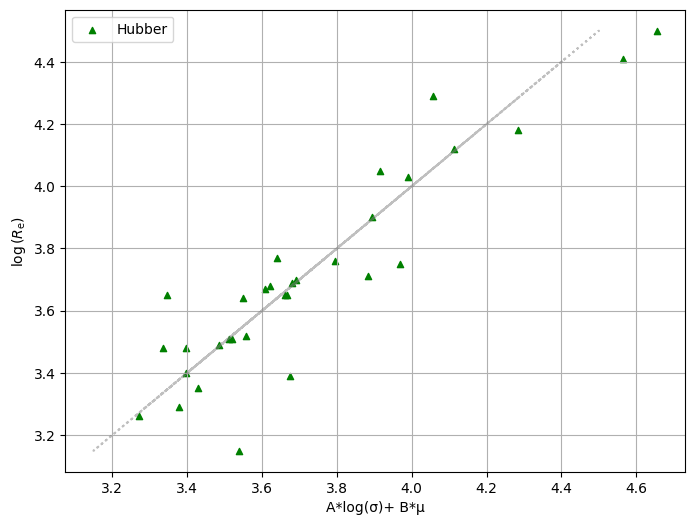

In [123]:
pipe=Pipeline([
    ('poly',PolynomialFeatures(degree=1)),
    ('scaller',StandardScaler()),
    ('model',HuberRegressor(alpha=0.1))
])
param_grid={                                                                
    'model__epsilon': np.linspace(1,2,10)                                       #valores de epsilon a probar
}
hubber_search = GridSearchCV(                                                   #buscamos la mejor combinacion de hiperparametros
    pipe,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)
hubber_search.fit(x_train,y_train)   

best_hubber=hubber_search.best_estimator_                                       #entrenamos el modelo con los mejores hiperparametros encontrados
y_pred=best_hubber.predict(x_test)
fig = plt.figure(figsize=(8,6))
plt.scatter(y_pred, y_test,s=20,marker='^', c='green',label='Hubber')
plt.plot(y_test,y_test,color='grey',alpha=0.5,linestyle='dotted')
plt.xlabel('A*log(σ)+ B*μ')
plt.ylabel(r'$\log\left(R_{\mathrm{e}}\right)$')
plt.grid(True)
plt.legend()
plt.show
print('R^2',best_hubber.score(x_test,y_test))


Finalmente se aplico el modelo de Hubber loss, el cual es mas robusto ante posibles outliers en la muestra, con hiperparametros epsilon y alpha los cuales se determinaron a partir del metodo GridSearch() el cual hace un k-fold CV (k=5) con todas las posibles combinaciones de hiperparametros y selecciona la combinacion con mayor score (-MSE, el signo negativo es porque a menor MSE mejor modelo). De esta forma obtuvimos una regresion con un R^2 ligeramente mayor a Ridge, lo cual nos indica que si bien la muestra tiene outliers, estos no son tantos como para afectar significativamente el desempeño de Ridge y Lasso.